

This project explores energy injustice by determining whether or not there exists statistically significant differences in the rooftop solar adoption between racial/ethnic groups. I use several machine learning techniques for handling non-linear data.


In [ ]:
import numpy as np
import pandas as pd

# Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

# Statistical Packages
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import patsy as pt

%matplotlib inline

In [ ]:
# The majority level sets the percentage of the census tract population that must self-identify as the same
# race/ethnicity in order for the census tract to be classified as that race/ethnicity.
majority_level = 50

# Variable of Interest
# For the LOWESS analysis, we explore racial disparity in rooftop PV deployment as a function of median household
# income and the percentage of households occupied by renters.
variable_of_interest = 'median_income'

# For this analysis I exclude Census Tracts Without Rooftop PV Installations, because resident's are likely to emulate
# technology adopted in their sorroudings (this is the seeding effect)
exclude_census_tracts_without_rooftop_PV = False

 Lad Data

In [ ]:
# Updated data can be found at these sources:
# https://www.google.com/get/sunroof/data-explorer/
# https://www.census.gov/data.html
data = pd.read_csv('data/CensusSunroofMerged.csv', encoding = "ISO-8859-1")

## Cleaning data

In [ ]:
# Remove census tracts where Google Project Sunroof analyzed < 95% of all buildings in the census tract
data = data[data.percent_covered >= 95]

# Remove census tracts where there is no potential to install rooftop PV
data = data[data.count_qualified !=0]

# Remove census tracts with median household income below the 2013 poverty threshold for a 4-person household
# https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-poverty-thresholds.html
data = data[data.Med_HHD_Inc_ACS_09_13 >= 23834]

data = data.reset_index()

Calculate state normalized solar deployment

In [ ]:
# Compute the solar deployment rate.
data['current_installs_relative_to_total_installs']=data['existing_installs_count']/data['count_qualified']*100

In [ ]:

# Normalize the solar deployment rate by the average solar deployment rate in each state.
# This mitigates the effects of variations across states, such as available solar resources, incentive programs and
# policies, and electricity prices.
df_state_mean = pd.DataFrame(columns=('state_name', 'state_mean_existing_installation_relative_to_potential'))

for state in set(data.state_name):
    mean_state = np.mean(data['current_installs_relative_to_total_installs'][(data['state_name'] == state)])
    df_state_mean.loc[state] = [state, mean_state]

data = pd.merge(data, df_state_mean, on='state_name')
data = data.drop(columns=['index', 'Unnamed: 0'])
data['normalized_existing_installation']=data['current_installs_relative_to_total_installs']/data['state_mean_existing_installation_relative_to_potential']

 For this project I will focus on the state of California for analysis. This is because of the ample data available

In [ ]:
data = data[data.state_name == 'California']
data = data.reset_index()

 Group Census Tracts By Their Majority Race/ethnicity

In [ ]:
# Create dataframes for each race/ethnicity in the study
df_asian       = pd.DataFrame(columns=['median_income', 'rental_ratio', 'solar_install'])
df_black       = pd.DataFrame(columns=['median_income', 'rental_ratio', 'solar_install'])
df_hisp        = pd.DataFrame(columns=['median_income', 'rental_ratio', 'solar_install'])
df_white       = pd.DataFrame(columns=['median_income', 'rental_ratio', 'solar_install'])
df_no_majority = pd.DataFrame(columns=['median_income', 'rental_ratio', 'solar_install'])

# Calculate the fraction of renter occupied households
data['rental_ratio'] = 100*data.Renter_Occp_HU_ACS_09_13/(data.Renter_Occp_HU_ACS_09_13+data.Owner_Occp_HU_ACS_09_13)

#Filter data by majority level to populate each race/ethnicity dataframe
for i in range(0, len(data)):
    if data['pct_NH_Asian_alone_ACS_09_13'][i] >= majority_level:
        df_asian.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['rental_ratio'][i], data['normalized_existing_installation'][i]]
    elif data['pct_NH_Blk_alone_ACS_09_13'][i] >= majority_level:
        df_black.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['rental_ratio'][i], data['normalized_existing_installation'][i]]
    elif data['pct_Hispanic_ACS_09_13'][i] >= majority_level:
        df_hisp.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['rental_ratio'][i], data['normalized_existing_installation'][i]]
    elif data['pct_NH_White_alone_ACS_09_13'][i] >= majority_level:
        df_white.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['rental_ratio'][i], data['normalized_existing_installation'][i]]
    else:
        df_no_majority.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['rental_ratio'][i], data['normalized_existing_installation'][i]]

In [ ]:
df_asian = df_asian.sort_values(by=['median_income'])
df_asian = df_asian.reset_index(drop = True)

df_black = df_black.sort_values(by=['median_income'])
df_black = df_black.reset_index(drop = True)

df_hisp = df_hisp.sort_values(by=['median_income'])
df_hisp = df_hisp.reset_index(drop = True)

df_white = df_white.sort_values(by=['median_income'])
df_white = df_white.reset_index(drop = True)

df_no_majority = df_no_majority.sort_values(by=['median_income'])
df_no_majority = df_no_majority.reset_index(drop = True)

Here I show how many census tracts are in each racial/ethnic majority group?  

In [ ]:

print('Number of Asian-majority census tracts:', len(df_asian.axes[0]))
print('Number of Black-majority census tracts:', len(df_black.axes[0]))
print('Number of Hispanic-majority census tracts:', len(df_hisp.axes[0]))
print('Number of White-majority census tracts:', len(df_white.axes[0]))
print('Number of No-majority (diverse) census tracts:', len(df_no_majority.axes[0]))

Number of Asian-majority census tracts: 319
Number of Black-majority census tracts: 68
Number of Hispanic-majority census tracts: 1981
Number of White-majority census tracts: 2543
Number of No-majority (diverse) census tracts: 1707


The next functions three functions are created to analyzes 1,000 bootstrap samples to determine the 95% confidence interval for the state-normalized solar installation rate as a function of median household income.

In [ ]:
def calc_MSE_polynomial_fit(poly_order, X_train, X_val, y_train, y_val):
    if poly_order == 1:
        X_train_poly = X_train
        X_val_poly = X_val
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)

    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()
    regr_poly.fit(X_train_poly, y_train)

    # Make predictions using the linear regression
    y_pred_poly_val = regr_poly.predict(X_val_poly)
    y_pred_poly_train = regr_poly.predict(X_train_poly)

    # Calculate the MSE for both the val and training sets
    MSE_val = mean_squared_error(y_val, y_pred_poly_val)
    MSE_train = mean_squared_error(y_train, y_pred_poly_train)

    return MSE_train, MSE_val

In [ ]:
def poly_order_cv(X,y,k,poly_order_max):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]

        # Adding a column in the X matrices for the intercept
        X_fold_train = np.array(X_fold_train).reshape(-1, 1)
        X_fold_val = np.array(X_fold_val).reshape(-1, 1)

        # Calculate the MSE for each polynomial order
        MSE_val_array = []
        MSE_train_array = []
        for poly_order in range(1,poly_order_max+1):
            [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_fold_train, X_fold_val, y_fold_train, y_fold_val)
            MSE_val_array.append(MSE_val)
            MSE_train_array.append(MSE_train)
        mses[fold] = MSE_val_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and the polynomial order where it occurs
    MSE_ave_val_min = min(mses.mses_ave)
    poly_order_MSE_ave_val_min = mses['mses_ave'].idxmin()+1

    return MSE_ave_val_min, poly_order_MSE_ave_val_min

In [ ]:
def bootstrap_polynomial_sample_analysis(X,y, poly_order, x_array):
    x_bootstrap_min = min(X)
    x_bootstrap_max = max(X)

    X_reshape = np.array(X).reshape(-1, 1)

    # Generate features up to the specified polynomial order
    if poly_order == 1:
        X_poly = X_reshape
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_poly = poly.fit_transform(X_reshape)

    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()
    regr_poly.fit(X_poly, y)

    # Do not extrapolate the bootstrapped regression beyond the range of the bootstrap data
    # For values below the lowest income in the bootstrap sample and above the highest income in the
    # bootstrap sample, place NaN values.
    entries_below_bootstrap_min = sum(x_array<x_bootstrap_min)
    y_pred_below_bootstrap_min = np.full(entries_below_bootstrap_min, np.nan)

    entries_above_bootstrap_max = sum(x_array>x_bootstrap_max)
    y_pred_above_bootstrap_max = np.full(entries_above_bootstrap_max, np.nan)

    # For entries within the bootstrap sample range, used your fitted regression to predict solar installation
    incomes_within_bootstrap_data =x_array[entries_below_bootstrap_min:(len(x_array) - entries_above_bootstrap_max)]
    if poly_order == 1:
        incomes_within_bootstrap_data = incomes_within_bootstrap_data.reshape(-1, 1)
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        incomes_within_bootstrap_data = poly.fit_transform(incomes_within_bootstrap_data.reshape(-1, 1))
    y_pred_within_bootstrap_data_range = regr_poly.predict(incomes_within_bootstrap_data)

    # Concatenate the predicted state normalized solar installation rate
    y_pred = np.concatenate((y_pred_below_bootstrap_min, y_pred_within_bootstrap_data_range, y_pred_above_bootstrap_max))

    return y_pred

I create a function, `bootstrap_polynomial_analysis` (a) In the first ellipse, you will determine which order of a polynomial (poly_order_MSE_ave_val_min) resulted in the lowest validation set mean squared error averaged across all folds of the cross-validation (MSE_ave_val_min). (b) In the second ellipse, you will need to predict state-normalized solar installation rate as a function of median household income for all incomes in x_array. (c) For the last three ellipses, you will need to calculate the median (50th percentile) and 95% confidence interval for the state-normalized solar installation rate as a function of median household income for all incomes in x_array. Each of these will have the same length as the array, x_array. Hint: There are many NaN values since the many bootstrap replicas will not have the data points at the highest and at the lowest income. I encourage you to consider using nanpercentile available in numpy when answering (c).

In [ ]:
def bootstrap_polynomial_analysis(df,variable_of_interest,poly_order_max, k):
    X = df[variable_of_interest]
    X = X.reset_index(drop = True)
    y = df.solar_install
    y = y.reset_index(drop = True)

    if variable_of_interest == 'median_income':
        x_array = np.arange(min(X), max(X), 100)

    [MSE_ave_val_min, poly_order_MSE_ave_val_min] = poly_order_cv(X,y,k,poly_order_max)
    print('The average MSE of the valuation sets:', MSE_ave_val_min)
    print('This occured when using a polynomial of order:', poly_order_MSE_ave_val_min)

    y_pred_bootstrap = pd.DataFrame()
    for i in range(0,1000):
        df_bootstrap = df.sample(n=len(df), replace=True)
        X_bootstrap  = df_bootstrap[variable_of_interest]
        X_bootstrap  = X_bootstrap.reset_index(drop = True)
        y_bootstrap  = df_bootstrap.solar_install
        y_bootstrap  = y_bootstrap.reset_index(drop = True)

        y_pred = bootstrap_polynomial_sample_analysis(X_bootstrap,y_bootstrap, poly_order_MSE_ave_val_min, x_array)
        y_pred_bootstrap[i] = y_pred


    y_pred_bootstrap_summary = pd.DataFrame()
    y_pred_bootstrap_summary['median'] = y_pred_bootstrap.median(axis=1)
    y_pred_bootstrap_summary['95_CI_high'] = np.nanpercentile(y_pred_bootstrap.to_numpy(),95,axis=1)
    y_pred_bootstrap_summary['95_CI_low'] = np.nanpercentile(y_pred_bootstrap.to_numpy(),5,axis=1)

    return y_pred_bootstrap_summary, x_array

You will perform a 5-fold cross validation and consider polynomials of order 1 (linear) to order 10.

In [ ]:
poly_order_max = 10
k = 5

Considering each racial/ethnic majority group, I print the average mean squared error of the valuation sets and the polynomial order which minimized this value. I also plot the median household income vs the state normalized solar installation rate. The plot will have points showing all census tracts in that racial/ethnic majority group, as well as the median and 95% confidence interval of the bootstrapped results.

The average MSE of the valuation sets: 0.7975514415410452
This occured when using a polynomial of order: 1


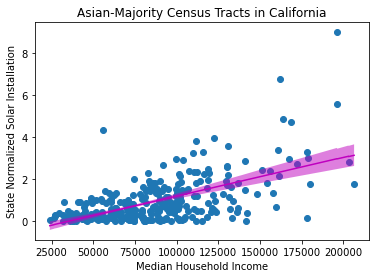

In [ ]:
# Asian
[y_pred_bootstrap_summary_asian, x_array_asian] = bootstrap_polynomial_analysis(df_asian,variable_of_interest,poly_order_max, k)

plt.scatter(df_asian.median_income, df_asian.solar_install)
plt.plot(x_array_asian, y_pred_bootstrap_summary_asian['median'], 'm')
plt.fill_between(x_array_asian, y_pred_bootstrap_summary_asian['95_CI_low'], y_pred_bootstrap_summary_asian['95_CI_high'], facecolor = 'm', alpha = 0.5)
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('Asian-Majority Census Tracts in California')
plt.show()

The average MSE of the valuation sets: 0.16588424312334982
This occured when using a polynomial of order: 9


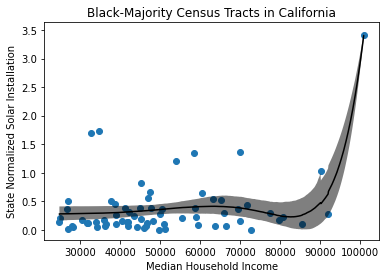

In [ ]:
# Black
[y_pred_bootstrap_summary_black, x_array_black] = bootstrap_polynomial_analysis(df_black,variable_of_interest,poly_order_max, k)

plt.scatter(df_black.median_income, df_black.solar_install)
plt.plot(x_array_black, y_pred_bootstrap_summary_black['median'], 'black')
plt.fill_between(x_array_black, y_pred_bootstrap_summary_black['95_CI_low'], y_pred_bootstrap_summary_black['95_CI_high'], facecolor = 'black', alpha = 0.5)
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('Black-Majority Census Tracts in California')
plt.show()

The average MSE of the valuation sets: 0.19253086202477082
This occured when using a polynomial of order: 2


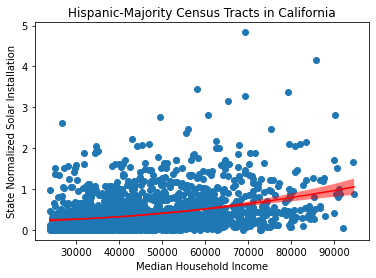

In [ ]:
# Hispanic
[y_pred_bootstrap_summary_hisp, x_array_hisp] = bootstrap_polynomial_analysis(df_hisp,variable_of_interest,poly_order_max, k)

plt.scatter(df_hisp.median_income, df_hisp.solar_install)
plt.plot(x_array_hisp, y_pred_bootstrap_summary_hisp['median'], 'r')
plt.fill_between(x_array_hisp, y_pred_bootstrap_summary_hisp['95_CI_low'], y_pred_bootstrap_summary_hisp['95_CI_high'], facecolor = 'r', alpha = 0.5)
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('Hispanic-Majority Census Tracts in California')
plt.show()

The average MSE of the valuation sets: 1.4649905184882102
This occured when using a polynomial of order: 1


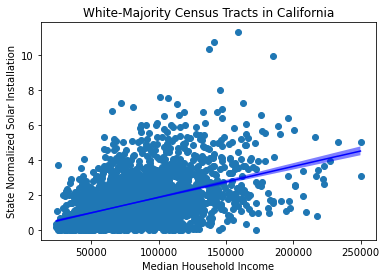

In [ ]:
# White
[y_pred_bootstrap_summary_white, x_array_white] = bootstrap_polynomial_analysis(df_white,variable_of_interest,poly_order_max, k)

plt.scatter(df_white.median_income, df_white.solar_install)
plt.plot(x_array_white, y_pred_bootstrap_summary_white['median'], 'b')
plt.fill_between(x_array_white, y_pred_bootstrap_summary_white['95_CI_low'], y_pred_bootstrap_summary_white['95_CI_high'], facecolor = 'b', alpha = 0.5)
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('White-Majority Census Tracts in California')
plt.show()

The average MSE of the valuation sets: 0.698743719593037
This occured when using a polynomial of order: 5


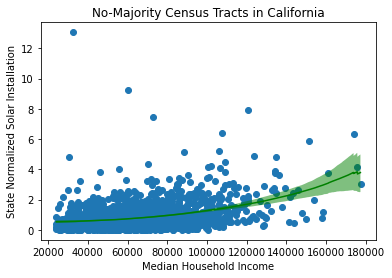

In [ ]:
# No-Majority
[y_pred_bootstrap_summary_no_majority, x_array_no_majority] = bootstrap_polynomial_analysis(df_no_majority,variable_of_interest,poly_order_max, k)

plt.scatter(df_no_majority.median_income, df_no_majority.solar_install)
plt.plot(x_array_no_majority, y_pred_bootstrap_summary_no_majority['median'], 'g')
plt.fill_between(x_array_no_majority, y_pred_bootstrap_summary_no_majority['95_CI_low'], y_pred_bootstrap_summary_no_majority['95_CI_high'], facecolor = 'g', alpha = 0.5)
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('No-Majority Census Tracts in California')
plt.show()

Store results for comparison later.

In [ ]:
# Asian
x_polynomial_reg_asian = x_array_asian
y_polynomial_reg_asian_95_low = y_pred_bootstrap_summary_asian['95_CI_low']
y_polynomial_reg_asian_95_high = y_pred_bootstrap_summary_asian['95_CI_high']
y_polynomial_reg_asian_median = y_pred_bootstrap_summary_asian['median']

# Black
x_polynomial_reg_black = x_array_black
y_polynomial_reg_black_95_low = y_pred_bootstrap_summary_black['95_CI_low']
y_polynomial_reg_black_95_high = y_pred_bootstrap_summary_black['95_CI_high']
y_polynomial_reg_black_median = y_pred_bootstrap_summary_black['median']

# Hispanic
x_polynomial_reg_hisp = x_array_hisp
y_polynomial_reg_hisp_95_low = y_pred_bootstrap_summary_hisp['95_CI_low']
y_polynomial_reg_hisp_95_high = y_pred_bootstrap_summary_hisp['95_CI_high']
y_polynomial_reg_hisp_median = y_pred_bootstrap_summary_hisp['median']

# White
x_polynomial_reg_white = x_array_white
y_polynomial_reg_white_95_low = y_pred_bootstrap_summary_white['95_CI_low']
y_polynomial_reg_white_95_high = y_pred_bootstrap_summary_white['95_CI_high']
y_polynomial_reg_white_median = y_pred_bootstrap_summary_white['median']

# No-Majority
x_polynomial_reg_no_majority = x_array_no_majority
y_polynomial_reg_no_majority_95_low = y_pred_bootstrap_summary_no_majority['95_CI_low']
y_polynomial_reg_no_majority_95_high = y_pred_bootstrap_summary_no_majority['95_CI_high']
y_polynomial_reg_no_majority_median = y_pred_bootstrap_summary_no_majority['median']

In [ ]:
# the 95% confidence interval does not mean the 95% of data points fall within this range. I'm 95 percent cofident that my predictions fall within
# this range

Let's put all racial/ethnic groups all on the same graph.

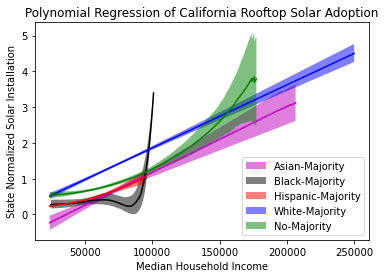

In [ ]:
# Asian
plt.plot(x_array_asian, y_pred_bootstrap_summary_asian['median'], 'm')
plt.fill_between(x_array_asian, y_pred_bootstrap_summary_asian['95_CI_low'], y_pred_bootstrap_summary_asian['95_CI_high'], facecolor = 'm', alpha = 0.5, label = 'Asian-Majority')

# Black
plt.plot(x_array_black, y_pred_bootstrap_summary_black['median'], 'black')
plt.fill_between(x_array_black, y_pred_bootstrap_summary_black['95_CI_low'], y_pred_bootstrap_summary_black['95_CI_high'], facecolor = 'black', alpha = 0.5, label = 'Black-Majority')

# Hispanic
plt.plot(x_array_hisp, y_pred_bootstrap_summary_hisp['median'], 'r')
plt.fill_between(x_array_hisp, y_pred_bootstrap_summary_hisp['95_CI_low'], y_pred_bootstrap_summary_hisp['95_CI_high'], facecolor = 'r', alpha = 0.5, label = 'Hispanic-Majority')

# White
plt.plot(x_array_white, y_pred_bootstrap_summary_white['median'], 'b')
plt.fill_between(x_array_white, y_pred_bootstrap_summary_white['95_CI_low'], y_pred_bootstrap_summary_white['95_CI_high'], facecolor = 'b', alpha = 0.5, label = 'White-Majority')

# No-Majority
plt.plot(x_array_no_majority, y_pred_bootstrap_summary_no_majority['median'], 'green')
plt.fill_between(x_array_no_majority, y_pred_bootstrap_summary_no_majority['95_CI_low'], y_pred_bootstrap_summary_no_majority['95_CI_high'], facecolor = 'green', alpha = 0.5, label = 'No-Majority')

plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('Polynomial Regression of California Rooftop Solar Adoption')
plt.legend()
plt.show()

In [ ]:
# the advantage of polynomial regression is that it can capture non-linear relationships within the data
# one disadvantage is that t is susceptible to overfitting with higher orger models and another disadvantage is that it performs poorly at the
# boundries of the data set



Here I fit a cubic spline (a spline of degree 3) with 7 degrees of freedom for the Asian-majority dataframe, and calculate the mean squared error

MSE is:  0.7158112377558109


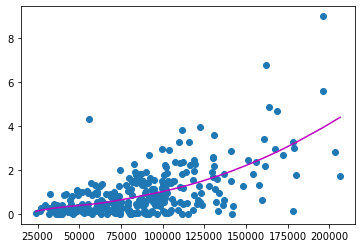

In [ ]:
# Use patsy to generate entire matrix of basis functions
X = pt.dmatrix('bs(median_income, df=7, degree=3, include_intercept=True)', df_asian)
y = np.asarray(df_asian['solar_install'])

# Fit linear regression model
model = sm.OLS(y, X).fit(disp=0)
y_pred = model.predict(X)

MSE = mean_squared_error(y, y_pred)
print('MSE is: ', MSE)

plt.plot(df_asian['median_income'], y_pred, 'm')
plt.scatter(df_asian.median_income, df_asian.solar_install)
plt.show()

Here I create a function, called `spline_degree_of_freedom_cv`, in the cell below that determines the optimal degrees of freedom to used based on k-fold cross-validation. The function will read in a dataframe (df), the number of folds for the k-fold cross-validation (k), the degree of the spline degree, and the maximum degrees of freedom that would be considered `degree_of_freedom_max`. The function will return the degrees of freedom `degree_of_freedom_MSE_ave_min` where the validation mean squared error averaged across all folds was minimized and the value of the minimum validation mean squared error averaged across all folds `MSE_ave_min`.

In [ ]:
def spline_degree_of_freedom_cv(df, k,degree, degree_of_freedom_max):


    X = pt.dmatrix('bs(median_income, df=degree_of_freedom_max, degree=degree, include_intercept=True)', df)
    y = np.asarray(df['solar_install'])

    kf = KFold(n_splits=k, shuffle=True, random_state=0)

    mses = pd.DataFrame()
    fold = 0
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]

        MSE_val_array = []
        MSE_train_array = []
        for i in range(k+1,degree_of_freedom_max+1):
            model = sm.OLS(y_fold_train, X_fold_train).fit(disp=0)

            y_pred_val = model.predict(X_fold_val)

            # Print the MSE for both the val and training sets
            MSE_val = mean_squared_error(y_fold_val,y_pred_val)

            MSE_val_array.append(MSE_val)
        mses[fold] = MSE_val_array
        fold = fold+1

    mses['mses_ave'] = mses.mean(axis=1)

    MSE_ave_min =  np.amin(list(mses['mses_ave']))
    degree_of_freedom_MSE_ave_min = k + 1 + list(mses['mses_ave']).index(MSE_ave_min)

    return MSE_ave_min, degree_of_freedom_MSE_ave_min

In [ ]:

df = df_asian

degree = 3 # cubic spline
k = 5      # 5-fold cross validation
degree_of_freedom_max = 10 # The maximum degrees of freedom that will be evaluated.

[MSE_ave_min, degree_of_freedom_MSE_ave_min] = spline_degree_of_freedom_cv(df,k, degree, degree_of_freedom_max)

print('The average MSE of the valuation sets:', MSE_ave_min)
print('This occured when using a polynomial of order:', degree_of_freedom_MSE_ave_min)

The average MSE of the valuation sets: 0.855770423143896
This occured when using a polynomial of order: 6


I calculate the 95% confidence interval for regression splines using the following method to save computational runtime:  https://stats.stackexchange.com/questions/44838/how-are-the-standard-errors-of-coefficients-calculated-in-a-regression.

In [ ]:
def confidence_interval(X, y, y_pred):
    # Covariance of coefficient estimates
    mse = np.sum(np.square(y_pred - y)) / y.size
    cov = mse * np.linalg.inv(X.T @ X)
    # Alternatively the covariance could be found using StatsModels:
    # cov = model.cov_params()

    # Calculate variance of f(x)
    var_f = np.diagonal((X @ cov) @ X.T)

    # Derive standard error of f(x) from variance
    se       = np.sqrt(abs(var_f))
    conf_int = 2*se

    return conf_int

Using the optimal degrees of freedom previously found, I plot the 95% confidence interval for a cubic spline on the Asian-majority data to relate the median household income to the state-normalized solar installation rate.

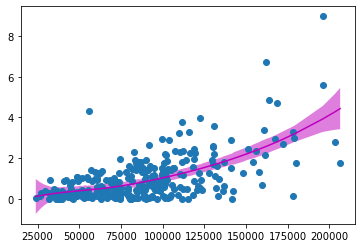

In [ ]:
X = pt.dmatrix('bs(median_income, df=degree_of_freedom_MSE_ave_min, degree=3, include_intercept=True)', df_asian)
y = np.asarray(df['solar_install'])

# Fit logistic regression model
model = sm.OLS(y, X).fit(disp=0)
y_pred = model.predict(X)

# Calculate the confidence interval
conf_int = confidence_interval(X, y, y_pred)

plt.plot(df['median_income'], y_pred, 'm')
plt.fill_between(df['median_income'], y_pred-conf_int, y_pred+conf_int, facecolor = 'm', alpha = 0.5)
plt.scatter(df_asian.median_income, df_asian.solar_install)
plt.show()

 I modify the function `spline_degree_of_freedom_cv` so that, in addition to returning MSE_ave_min and degree_of_freedom_MSE_ave_min, it will return conf_int (which can be added to and subtracted from y_pred to get the 95% confidence_interval) and y_pred (which is the predicted state-normalized solar installation rate).

In [ ]:
def spline_degree_of_freedom_cv_with_CI(df, k, degree, degree_of_freedom_max):


    [mse1, dff] = spline_degree_of_freedom_cv(df, k,degree, degree_of_freedom_max)

    X = pt.dmatrix('bs(median_income, df=dff, degree=degree, include_intercept=True)', df)
    y = np.asarray(df['solar_install'])

    # Fit linear regression model
    model = sm.OLS(y, X).fit(disp=0)
    y_pred = model.predict(X)
    conf_int = confidence_interval(X, y, y_pred)

    MSE_ave_min =  mse1
    degree_of_freedom_MSE_ave_min = dff

    return MSE_ave_min, degree_of_freedom_MSE_ave_min, conf_int, y_pred

I use the function above to plot the 95% confidence intervals for all racial/ethnic majority groups.

The MSE for the Asian-majority tracts: 0.855770423143896
The MSE for the Black-majority tracts: 0.23120733088610318
The MSE for the Hispanic-majority tracts: 0.19417463483937408
The MSE for the White-majority tracts: 1.4716005365622653
The MSE for the No-majority tracts: 0.7070395360688708


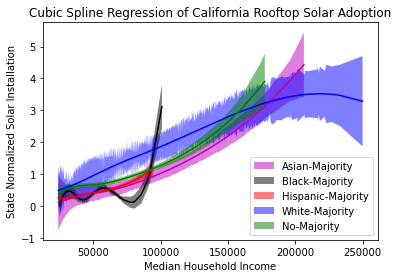

In [ ]:
# Asian
[MSE_ave_min_asian, degree_of_freedom_MSE_ave_min_asian, conf_int_asian, y_pred_asian]=spline_degree_of_freedom_cv_with_CI(df_asian, 5, 3, 10)
plt.plot(df_asian['median_income'], y_pred_asian, 'm')
plt.fill_between(df_asian['median_income'], y_pred_asian-conf_int_asian, y_pred_asian+conf_int_asian, facecolor = 'm', alpha = 0.5, label = 'Asian-Majority')

# Black
[MSE_ave_min_black, degree_of_freedom_MSE_ave_min_black, conf_int_black, y_pred_black]=spline_degree_of_freedom_cv_with_CI(df_black, 5, 3, 10)
plt.plot(df_black['median_income'], y_pred_black, 'black')
plt.fill_between(df_black['median_income'], y_pred_black-conf_int_black, y_pred_black+conf_int_black, facecolor = 'black', alpha = 0.5, label = 'Black-Majority')

# Hispanic
[MSE_ave_min_hisp, degree_of_freedom_MSE_ave_min_hisp, conf_int_hisp, y_pred_hisp]=spline_degree_of_freedom_cv_with_CI(df_hisp, 5, 3, 10)
plt.plot(df_hisp['median_income'], y_pred_hisp, 'r')
plt.fill_between(df_hisp['median_income'], y_pred_hisp-conf_int_hisp, y_pred_hisp+conf_int_hisp, facecolor = 'r', alpha = 0.5, label = 'Hispanic-Majority')

# White
[MSE_ave_min_white, degree_of_freedom_MSE_ave_min_white, conf_int_white, y_pred_white]=spline_degree_of_freedom_cv_with_CI(df_white, 5, 3, 10)
plt.plot(df_white['median_income'], y_pred_white, 'b')
plt.fill_between(df_white['median_income'], y_pred_white-conf_int_white, y_pred_white+conf_int_white, facecolor = 'b', alpha = 0.5, label = 'White-Majority')

# No-Majority
[MSE_ave_min_no_majority, degree_of_freedom_MSE_ave_min_no_majority, conf_int_no_majority, y_pred_no_majority]=spline_degree_of_freedom_cv_with_CI(df_no_majority, 5, 3, 10)
plt.plot(df_no_majority['median_income'], y_pred_no_majority, 'g')
plt.fill_between(df_no_majority['median_income'], y_pred_no_majority-conf_int_no_majority, y_pred_no_majority+conf_int_no_majority, facecolor = 'g', alpha = 0.5, label = 'No-Majority')

# Print these values for comparison to GAMs models
print('The MSE for the Asian-majority tracts:', MSE_ave_min_asian)
print('The MSE for the Black-majority tracts:', MSE_ave_min_black)
print('The MSE for the Hispanic-majority tracts:', MSE_ave_min_hisp)
print('The MSE for the White-majority tracts:', MSE_ave_min_white)
print('The MSE for the No-majority tracts:', MSE_ave_min_no_majority)

# Store these values for use in GAMs models
deg_of_freedom_income_asian = degree_of_freedom_MSE_ave_min_asian
deg_of_freedom_income_black = degree_of_freedom_MSE_ave_min_black
deg_of_freedom_income_hisp = degree_of_freedom_MSE_ave_min_hisp
deg_of_freedom_income_white = degree_of_freedom_MSE_ave_min_white
deg_of_freedom_income_no_majority = degree_of_freedom_MSE_ave_min_no_majority

plt.title('Cubic Spline Regression of California Rooftop Solar Adoption')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.legend(loc = 'lower right')
plt.show()

Store results for comparison later.

In [ ]:
# Asian
x_spline_asian = df_asian['median_income']
y_spline_asian_95_low = y_pred_asian-conf_int_asian
y_spline_asian_95_high = y_pred_asian+conf_int_asian
y_spline_asian_median = y_pred_asian

# Black
x_spline_black = df_black['median_income']
y_spline_black_95_low = y_pred_black-conf_int_black
y_spline_black_95_high = y_pred_black+conf_int_black
y_spline_black_median = y_pred_black

# Hispanic
x_spline_hisp = df_hisp['median_income']
y_spline_hisp_95_low = y_pred_hisp-conf_int_hisp
y_spline_hisp_95_high = y_pred_hisp+conf_int_hisp
y_spline_hisp_median = y_pred_hisp

# White
x_spline_white = df_white['median_income']
y_spline_white_95_low = y_pred_white-conf_int_white
y_spline_white_95_high = y_pred_white+conf_int_white
y_spline_white_median = y_pred_white

# No-Majority
x_spline_no_majority = df_no_majority['median_income']
y_spline_no_majority_95_low = y_pred_no_majority-conf_int_no_majority
y_spline_no_majority_95_high = y_pred_no_majority+conf_int_no_majority
y_spline_no_majority_median = y_pred_no_majority

 Reconstruct the plot above titled, "Cubic Spline Regression of California Rooftop Solar Adoption," for natural splines.

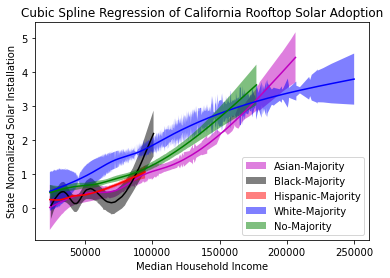

In [ ]:
# Asian
[MSE_ave_min_asian, degree_of_freedom_MSE_ave_min_asian, conf_int_asian, y_pred_asian]=natural_spline_degree_of_freedom_cv_with_CI(df_asian, 5, 3, 10)
plt.plot(df_asian['median_income'], y_pred_asian, 'm')
plt.fill_between(df_asian['median_income'], y_pred_asian-conf_int_asian, y_pred_asian+conf_int_asian, facecolor = 'm', alpha = 0.5, label = 'Asian-Majority')

# Black
[MSE_ave_min_black, degree_of_freedom_MSE_ave_min_black, conf_int_black, y_pred_black]=natural_spline_degree_of_freedom_cv_with_CI(df_black, 5, 3, 10)
plt.plot(df_black['median_income'], y_pred_black, 'black')
plt.fill_between(df_black['median_income'], y_pred_black-conf_int_black, y_pred_black+conf_int_black, facecolor = 'black', alpha = 0.5, label = 'Black-Majority')

# Hispanic
[MSE_ave_min_hisp, degree_of_freedom_MSE_ave_min_hisp, conf_int_hisp, y_pred_hisp]=natural_spline_degree_of_freedom_cv_with_CI(df_hisp, 5, 3, 10)
plt.plot(df_hisp['median_income'], y_pred_hisp, 'r')
plt.fill_between(df_hisp['median_income'], y_pred_hisp-conf_int_hisp, y_pred_hisp+conf_int_hisp, facecolor = 'r', alpha = 0.5, label = 'Hispanic-Majority')

# White
[MSE_ave_min_white, degree_of_freedom_MSE_ave_min_white, conf_int_white, y_pred_white]=natural_spline_degree_of_freedom_cv_with_CI(df_white, 5, 3, 10)
plt.plot(df_white['median_income'], y_pred_white, 'b')
plt.fill_between(df_white['median_income'], y_pred_white-conf_int_white, y_pred_white+conf_int_white, facecolor = 'b', alpha = 0.5, label = 'White-Majority')

# No-Majority
[MSE_ave_min_no_majority, degree_of_freedom_MSE_ave_min_no_majority, conf_int_no_majority, y_pred_no_majority]=natural_spline_degree_of_freedom_cv_with_CI(df_no_majority, 5, 3, 10)
plt.plot(df_no_majority['median_income'], y_pred_no_majority, 'g')
plt.fill_between(df_no_majority['median_income'], y_pred_no_majority-conf_int_no_majority, y_pred_no_majority+conf_int_no_majority, facecolor = 'g', alpha = 0.5, label = 'No-Majority')

plt.title('Cubic Spline Regression of California Rooftop Solar Adoption')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
def natural_spline_degree_of_freedom_cv(df, k,degree, degree_of_freedom_max):


    X = pt.dmatrix('cr(median_income, df=degree_of_freedom_max)', df)
    y = np.asarray(df['solar_install'])

    kf = KFold(n_splits=k, shuffle=True, random_state=0)

    mses = pd.DataFrame()
    fold = 0
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]

        MSE_val_array = []
        MSE_train_array = []
        for i in range(k+1,degree_of_freedom_max+1):
            model = sm.OLS(y_fold_train, X_fold_train).fit(disp=0)

            y_pred_val = model.predict(X_val)
            y_pred_train = model.predict(X_train)

            # Print the MSE for both the val and training sets
            MSE_val = mean_squared_error(y_fold_train,y_pred_val)

            MSE_val_array.append(MSE_val)
        mses[fold] = MSE_val_array
        fold = fold+1

    mses['mses_ave'] = mses.mean(axis=1)

    MSE_ave_min =  np.amin(list(mses['mses_ave']))
    degree_of_freedom_MSE_ave_min = k + 1 + list(mses['mses_ave']).index(MSE_ave_min)

    return MSE_ave_min, degree_of_freedom_MSE_ave_min

In [ ]:
def natural_spline_degree_of_freedom_cv_with_CI(df, k, degree, degree_of_freedom_max):


    [mse1, dff] = spline_degree_of_freedom_cv(df, k,degree, degree_of_freedom_max)

    X = pt.dmatrix('cr(median_income, df=dff)', df)
    y = np.asarray(df['solar_install'])

    # Fit linear regression model
    model = sm.OLS(y, X).fit(disp=0)
    y_pred = model.predict(X)
    conf_int = confidence_interval(X, y, y_pred)

    MSE_ave_min =  mse1
    degree_of_freedom_MSE_ave_min = dff

    return MSE_ave_min, degree_of_freedom_MSE_ave_min, conf_int, y_pred

In [ ]:
# The advantages of both regression and natural splines is that thery both capture non-linear relationships with lower order polynomials that
# are less susceptible to over fitting. However, the regresion spline has the disadvantage of tail effect at the boundries of the data set
# the natural spline, on the other hand, does not create such problems

I use lowess to fit the Asian-majority data frame. First I gues a span of 0.25. Therefore, for each target point, $x_0$, 25% of the training observations that are closest to $x_0$ will be used and 75% of the data that is outside this span will be ignored.

MSE is:  0.7157476614298142


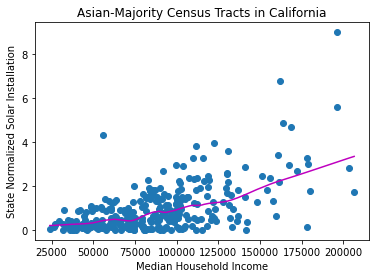

In [ ]:
# Designate the input parameters for LOWESS
fraction = 0.25
X = df_asian[variable_of_interest]
y = df_asian['solar_install']

# Fit LOWESS model
lowess = sm.nonparametric.lowess(y, X, frac=fraction)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
y_pred_lowess = f(X)

# Calculate the mean squared error
MSE = mean_squared_error(y, y_pred) #MSE of training data; Notice there was not train/test split
print('MSE is: ', MSE)

# Plot the results
plt.plot(X, y_pred_lowess, 'm')
plt.scatter(X, y)
plt.title('Asian-Majority Census Tracts in California')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.show()

The function below implements cross-validation to determine the most appropriate span.

In [ ]:
def lowess_cv(X, y, k, number_fractions_considered):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]

        MSE_array = []
        interval = 1/number_fractions_considered
        fractions_considered = np.arange(interval,1+interval,interval)
        for fraction in fractions_considered:
            # Fit LOWESS model
            lowess = sm.nonparametric.lowess(y_fold_train, X_fold_train, frac=fraction)
            lowess_x = list(zip(*lowess))[0]
            lowess_y = list(zip(*lowess))[1]
            f = interp1d(lowess_x, lowess_y, bounds_error=False)
            y_pred = f(X_fold_val)

            # Calculate the mean squared error
            if np.isnan(y_pred).any()==True:
                y_comparison = pd.DataFrame({'y_pred': np.array(y_pred), 'y_fold_val': np.array(y_fold_val)}, columns=['y_pred', 'y_fold_val'])
                y_comparison = y_comparison.dropna()
                MSE = mean_squared_error(y_comparison.y_fold_val, y_comparison.y_pred)
            else:
                MSE = mean_squared_error(y_fold_val, y_pred)
            MSE_array.append(MSE)

        mses[fold] = MSE_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and with which fraction (span) does it occur
    MSE_ave_min = min(mses.mses_ave)
    span_MSE_ave_min_index = mses['mses_ave'].idxmin()
    span_MSE_ave_min = fractions_considered[span_MSE_ave_min_index]

    return MSE_ave_min, span_MSE_ave_min

 Here I use 5-fold cross-validation to determine the optimal span for a lowess model fit of the state normalized solar adoption as a function of median household income for Asian-majority census tracts in California. Consider spans of 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, and 100%.

The average MSE across the folds when using optimal span: 0.8033329783559278
The optimal span: 0.5


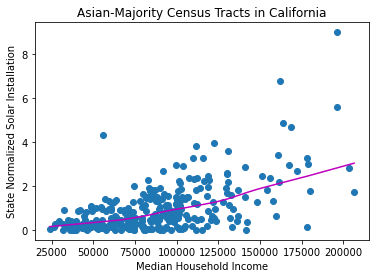

In [ ]:

# Define input parameters for the LOWESS analysis
X = df_asian[variable_of_interest]
y = df_asian['solar_install']
number_fractions_considered =10
k = 5

# Use cross-validation to determine the validation MSE and optimal
[MSE_ave_min, span_MSE_ave_min] = lowess_cv(X, y, k, number_fractions_considered)
print('The average MSE across the folds when using optimal span:', MSE_ave_min)
print('The optimal span:', span_MSE_ave_min)

# Fit LOWESS model using optimal span
lowess = sm.nonparametric.lowess(y, X, frac=span_MSE_ave_min)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
y_pred_lowess = f(X)

# Plot the results
plt.plot(X, y_pred_lowess, 'm')
plt.scatter(X, y)

plt.title('Asian-Majority Census Tracts in California')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.show()

In [ ]:

# The LOWESS with the span of 0.25 gave a better fit than the one calculated from the range of fractions. this shows that we need to use finer
# increments in our range of span values

Next, I find the 95% confidence interval using bootstrapping. The function below, bootstrap_lowess_sample_analysis, is able to take a bootstrap sample (X, y), the span (fraction), and an array over which you want to predict values using the loswess fit of the bootstrap sample (x_array).

In [ ]:
def bootstrap_lowess_sample_analysis(X,y, fraction, x_array):
    x_bootstrap_min = min(X)
    x_bootstrap_max = max(X)

    # Fit LOWESS model
    lowess = sm.nonparametric.lowess(y, X, frac=fraction)
    lowess_x = list(zip(*lowess))[0]
    lowess_y = list(zip(*lowess))[1]
    f = interp1d(lowess_x, lowess_y, bounds_error=False)

    # For values below the lowest income in the bootstrap sample and above the highest income in the
    # bootstrap sample, place NaN values.
    entries_below_bootstrap_min = sum(x_array<x_bootstrap_min)
    y_pred_below_bootstrap_min = np.full(entries_below_bootstrap_min, np.nan)

    entries_above_bootstrap_max = sum(x_array>x_bootstrap_max)
    y_pred_above_bootstrap_max = np.full(entries_above_bootstrap_max, np.nan)

    # For entries within the bootstrap sample range, used your fitted regression to predict solar installation
    incomes_within_bootstrap_data =x_array[entries_below_bootstrap_min:(len(x_array) - entries_above_bootstrap_max)]
    y_pred_within_bootstrap_data_range = f(incomes_within_bootstrap_data)

    # Concatenate the predicted solar installations for all three regions
    y_pred = np.concatenate((y_pred_below_bootstrap_min, y_pred_within_bootstrap_data_range, y_pred_above_bootstrap_max))

    return y_pred




 This function creates a lowess model on a dataframe with a feature matrix, the variable of interest, and the response, y, will be the state normalized solar installation. K-fold cross-validation will be used to determine and print out the optimal span and the average mean squared error across the folds when using the optimal span. I use 100 bootstrap samples to determine the median and 95% confidence interval for the lowess fit. The function will return y_pred_bootstrap summary and x_array. The pandas dataframe, y_pred_bootstap_summary, will contain 3 columns: one column will contain the median LOWESS fit ('median'), one column will contain the upper range of the 95% confidence interval ('95_CI_high'), and the final column will contain the lower range of the 95% confidence interval ('95_CI_low'). The array, x_array, will be an array from the minimum to maximum value of the variable of interest in the dataframe, df. When the variable of interest is 'median_income' the increments of the x_array will be \$100 dollars.

In [ ]:
def bootstrap_lowess_analysis(df,variable_of_interest,k,number_fractions_considered):
    X = df[variable_of_interest]
    X = X.reset_index(drop = True)
    y = df.solar_install
    y = y.reset_index(drop = True)

    if variable_of_interest == 'median_income':
        x_array = np.arange(min(X), max(X), 100)

    [MSE_ave_min, span_MSE_ave_min] = lowess_cv(X, y, k, number_fractions_considered) # Enter several lines of code

    print('The average MSE across the folds when using optimal span:', MSE_ave_min)
    print('The optimal span:', span_MSE_ave_min)

    y_pred_bootstrap = pd.DataFrame()
    for i in range(0,1000):
        df_bootstrap = df.sample(n=len(df), replace=True)
        X_bootstrap  = df_bootstrap[variable_of_interest]
        X_bootstrap  = X_bootstrap.reset_index(drop = True)
        y_bootstrap  = df_bootstrap.solar_install
        y_bootstrap  = y_bootstrap.reset_index(drop = True)

        y_pred = bootstrap_lowess_sample_analysis(X_bootstrap,y_bootstrap, span_MSE_ave_min, x_array)
        y_pred_bootstrap[i] = y_pred

    y_pred_bootstrap_summary = pd.DataFrame()
    y_pred_bootstrap_summary['median'] = y_pred_bootstrap.median(axis=1)
    y_pred_bootstrap_summary['95_CI_high'] = np.nanpercentile(y_pred_bootstrap.to_numpy(),95,axis=1)
    y_pred_bootstrap_summary['95_CI_low'] = np.nanpercentile(y_pred_bootstrap.to_numpy(),5,axis=1)

    return y_pred_bootstrap_summary, x_array

In [ ]:
number_fractions_considered = 10
k = 5 #folds

The average MSE across the folds when using optimal span: 0.8033329783559278
The optimal span: 0.5


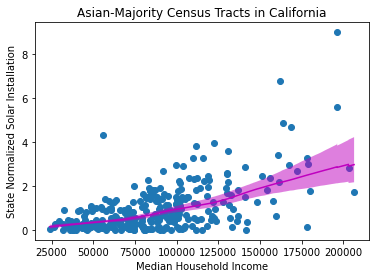

In [ ]:
# Asian
[y_pred_bootstrap_summary_asian, x_array_asian] = bootstrap_lowess_analysis(df_asian,variable_of_interest,k,number_fractions_considered)

plt.scatter(df_asian.median_income, df_asian.solar_install)
plt.plot(x_array_asian, y_pred_bootstrap_summary_asian['median'], 'm')
plt.fill_between(x_array_asian, y_pred_bootstrap_summary_asian['95_CI_low'], y_pred_bootstrap_summary_asian['95_CI_high'], facecolor = 'm', alpha = 0.5)
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('Asian-Majority Census Tracts in California')
plt.show()

The average MSE across the folds when using optimal span: 0.16702053149874624
The optimal span: 1.0


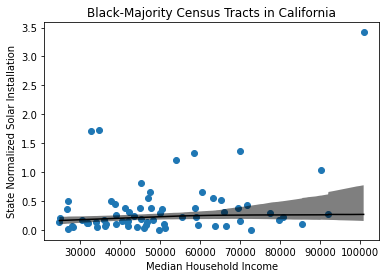

In [ ]:
# Black
[y_pred_bootstrap_summary_black, x_array_black] = bootstrap_lowess_analysis(df_black,variable_of_interest,k,number_fractions_considered)

plt.scatter(df_black.median_income, df_black.solar_install)
plt.plot(x_array_black, y_pred_bootstrap_summary_black['median'], 'black')
plt.fill_between(x_array_black, y_pred_bootstrap_summary_black['95_CI_low'], y_pred_bootstrap_summary_black['95_CI_high'], facecolor = 'black', alpha = 0.5)

plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('Black-Majority Census Tracts in California')
plt.show()

The average MSE across the folds when using optimal span: 0.20951193628308779
The optimal span: 0.1


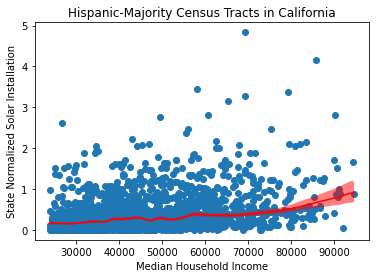

In [ ]:
# Hispanic
[y_pred_bootstrap_summary_hisp, x_array_hisp] = bootstrap_lowess_analysis(df_hisp,variable_of_interest,k,number_fractions_considered)

plt.scatter(df_hisp.median_income, df_hisp.solar_install)
plt.plot(x_array_hisp, y_pred_bootstrap_summary_hisp['median'], 'r')
plt.fill_between(x_array_hisp, y_pred_bootstrap_summary_hisp['95_CI_low'], y_pred_bootstrap_summary_hisp['95_CI_high'], facecolor = 'r', alpha = 0.5)

plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('Hispanic-Majority Census Tracts in California')
plt.show()

The average MSE across the folds when using optimal span: 1.5281202379307508
The optimal span: 1.0


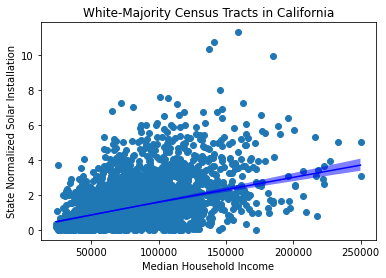

In [ ]:
# White
[y_pred_bootstrap_summary_white, x_array_white] = bootstrap_lowess_analysis(df_white,variable_of_interest,k,number_fractions_considered)

plt.scatter(df_white.median_income, df_white.solar_install)
plt.plot(x_array_white, y_pred_bootstrap_summary_white['median'], 'b')
plt.fill_between(x_array_white, y_pred_bootstrap_summary_white['95_CI_low'], y_pred_bootstrap_summary_white['95_CI_high'], facecolor = 'b', alpha = 0.5)

plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('White-Majority Census Tracts in California')
plt.show()

The average MSE across the folds when using optimal span: 0.7373351240330027
The optimal span: 0.4


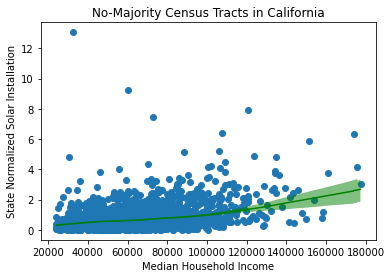

In [ ]:
# No-Majority
[y_pred_bootstrap_summary_no_majority, x_array_no_majority] = bootstrap_lowess_analysis(df_no_majority,variable_of_interest,k,number_fractions_considered)

plt.scatter(df_no_majority.median_income, df_no_majority.solar_install)
plt.plot(x_array_no_majority, y_pred_bootstrap_summary_no_majority['median'], 'g')
plt.fill_between(x_array_no_majority, y_pred_bootstrap_summary_no_majority['95_CI_low'], y_pred_bootstrap_summary_no_majority['95_CI_high'], facecolor = 'g', alpha = 0.5)

plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.title('No-Majority Census Tracts in California')
plt.show()

In [ ]:
# Asian
x_lowess_asian = x_array_asian
y_lowess_asian_95_low = y_pred_bootstrap_summary_asian['95_CI_low']
y_lowess_asian_95_high = y_pred_bootstrap_summary_asian['95_CI_high']
y_lowess_asian_median = y_pred_bootstrap_summary_asian['median']

# Black
x_lowess_black = x_array_black
y_lowess_black_95_low = y_pred_bootstrap_summary_black['95_CI_low']
y_lowess_black_95_high = y_pred_bootstrap_summary_black['95_CI_high']
y_lowess_black_median = y_pred_bootstrap_summary_black['median']

# Hispanic
x_lowess_hisp = x_array_hisp
y_lowess_hisp_95_low = y_pred_bootstrap_summary_hisp['95_CI_low']
y_lowess_hisp_95_high = y_pred_bootstrap_summary_hisp['95_CI_high']
y_lowess_hisp_median = y_pred_bootstrap_summary_hisp['median']

# White
x_lowess_white = x_array_white
y_lowess_white_95_low = y_pred_bootstrap_summary_white['95_CI_low']
y_lowess_white_95_high = y_pred_bootstrap_summary_white['95_CI_high']
y_lowess_white_median = y_pred_bootstrap_summary_white['median']

# No-Majority
x_lowess_no_majority = x_array_no_majority
y_lowess_no_majority_95_low = y_pred_bootstrap_summary_no_majority['95_CI_low']
y_lowess_no_majority_95_high = y_pred_bootstrap_summary_no_majority['95_CI_high']
y_lowess_no_majority_median = y_pred_bootstrap_summary_no_majority['median']

Let's use that function to plot the 95% confidence intervals for all racial/ethnic majority groups.

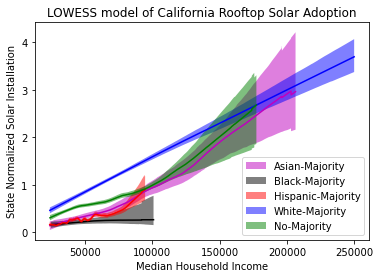

In [ ]:
# Asian
plt.plot(x_lowess_asian, y_lowess_asian_median, 'm')
plt.fill_between(x_lowess_asian, y_lowess_asian_95_low, y_lowess_asian_95_high, facecolor = 'm', alpha = 0.5, label = 'Asian-Majority')

# Black
plt.plot(x_lowess_black, y_lowess_black_median, 'black')
plt.fill_between(x_lowess_black, y_lowess_black_95_low, y_lowess_black_95_high, facecolor = 'black', alpha = 0.5, label = 'Black-Majority')

# Hispanic
plt.plot(x_lowess_hisp, y_lowess_hisp_median, 'r')
plt.fill_between(x_lowess_hisp, y_lowess_hisp_95_low, y_lowess_hisp_95_high, facecolor = 'r', alpha = 0.5, label = 'Hispanic-Majority')

# White
plt.plot(x_lowess_white, y_lowess_white_median, 'b')
plt.fill_between(x_lowess_white, y_lowess_white_95_low, y_lowess_white_95_high, facecolor = 'b', alpha = 0.5, label = 'White-Majority')

# No-Majority
plt.plot(x_lowess_no_majority, y_lowess_no_majority_median, 'g')
plt.fill_between(x_lowess_no_majority, y_lowess_no_majority_95_low, y_lowess_no_majority_95_high, facecolor = 'g', alpha = 0.5, label = 'No-Majority')

plt.title('LOWESS model of California Rooftop Solar Adoption')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# Some Thoughts:
# The advantage of lowess is that is it flexible but not prone to overfitting like polynomials, it doesn't suffer from tail effecct
# and it is simple to use. However it relies on data sets that are densely packed to work well. Also it becomes computatioinally expensive  when
# we have large dense datasets

### Consider the different fits used to relate median household income to state-normalized solar installation rates in California for the various racial/ethnic majority groups.



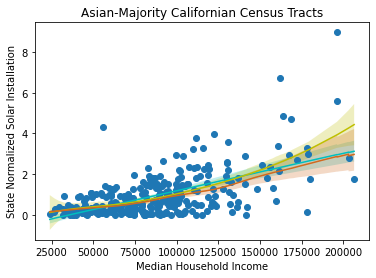

In [ ]:
# Asian

# Polynomial Regression
plt.fill_between(x_polynomial_reg_asian, y_polynomial_reg_asian_95_low, y_polynomial_reg_asian_95_high, facecolor = 'c', alpha = 0.25)
plt.plot(x_polynomial_reg_asian, y_polynomial_reg_asian_median, 'c')

# Spline
plt.fill_between(x_spline_asian, y_spline_asian_95_low, y_spline_asian_95_high, facecolor = 'y', alpha = 0.25)
plt.plot(x_spline_asian, y_spline_asian_median, 'y')

# LOWESS
plt.fill_between(x_lowess_asian, y_lowess_asian_95_low, y_lowess_asian_95_high, facecolor = 'chocolate', alpha = 0.25)
plt.plot(x_lowess_asian, y_lowess_asian_median, color = 'chocolate')

plt.scatter(df_asian.median_income, df_asian.solar_install)
plt.title('Asian-Majority Californian Census Tracts')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.show()

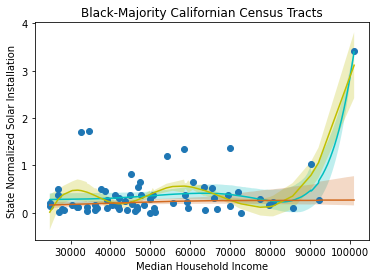

In [ ]:
# Black

# Polynomial Regression
plt.fill_between(x_polynomial_reg_black, y_polynomial_reg_black_95_low, y_polynomial_reg_black_95_high, facecolor = 'c', alpha = 0.25)
plt.plot(x_polynomial_reg_black, y_polynomial_reg_black_median, 'c')

# Spline
plt.fill_between(x_spline_black, y_spline_black_95_low, y_spline_black_95_high, facecolor = 'y', alpha = 0.25)
plt.plot(x_spline_black, y_spline_black_median, 'y')

# LOWESS
plt.fill_between(x_lowess_black, y_lowess_black_95_low, y_lowess_black_95_high, facecolor = 'chocolate', alpha = 0.25)
plt.plot(x_lowess_black, y_lowess_black_median, 'chocolate')

plt.scatter(df_black.median_income, df_black.solar_install)
plt.title('Black-Majority Californian Census Tracts')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.show()

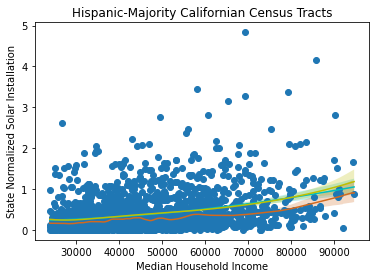

In [ ]:
# Hispanic

# Polynomial Regression
plt.fill_between(x_polynomial_reg_hisp, y_polynomial_reg_hisp_95_low, y_polynomial_reg_hisp_95_high, facecolor = 'c', alpha = 0.25)
plt.plot(x_polynomial_reg_hisp, y_polynomial_reg_hisp_median, 'c')

# Spline
plt.fill_between(x_spline_hisp, y_spline_hisp_95_low, y_spline_hisp_95_high, facecolor = 'y', alpha = 0.25)
plt.plot(x_spline_hisp, y_spline_hisp_median, 'y')

# LOWESS
plt.fill_between(x_lowess_hisp, y_lowess_hisp_95_low, y_lowess_hisp_95_high, facecolor = 'chocolate', alpha = 0.25)
plt.plot(x_lowess_hisp, y_lowess_hisp_median, 'chocolate')

plt.scatter(df_hisp.median_income, df_hisp.solar_install)
plt.title('Hispanic-Majority Californian Census Tracts')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.show()

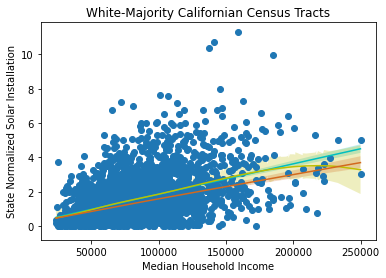

In [ ]:
# White

# Polynomial Regression
plt.fill_between(x_polynomial_reg_white, y_polynomial_reg_white_95_low, y_polynomial_reg_white_95_high, facecolor = 'c', alpha = 0.25)
plt.plot(x_polynomial_reg_white, y_polynomial_reg_white_median, 'c')

# Spline
plt.fill_between(x_spline_white, y_spline_white_95_low, y_spline_white_95_high, facecolor = 'y', alpha = 0.25)
plt.plot(x_spline_white, y_spline_white_median, 'y')

# LOWESS
plt.fill_between(x_lowess_white, y_lowess_white_95_low, y_lowess_white_95_high, facecolor = 'chocolate', alpha = 0.25)
plt.plot(x_lowess_white, y_lowess_white_median, 'chocolate')

plt.scatter(df_white.median_income, df_white.solar_install)
plt.title('White-Majority Californian Census Tracts')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.show()

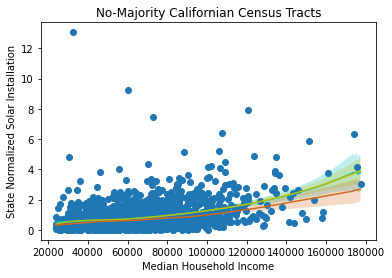

In [ ]:
# No-Majority

# Polynomial Regression
plt.fill_between(x_polynomial_reg_no_majority, y_polynomial_reg_no_majority_95_low, y_polynomial_reg_no_majority_95_high, facecolor = 'c', alpha = 0.25)
plt.plot(x_polynomial_reg_no_majority, y_polynomial_reg_no_majority_median, 'c')

# Spline
plt.fill_between(x_spline_no_majority, y_spline_no_majority_95_low, y_spline_no_majority_95_high, facecolor = 'y', alpha = 0.25)
plt.plot(x_spline_no_majority, y_spline_no_majority_median, 'y')

# LOWESS
plt.fill_between(x_lowess_no_majority, y_lowess_no_majority_95_low, y_lowess_no_majority_95_high, facecolor = 'chocolate', alpha = 0.25)
plt.plot(x_lowess_no_majority, y_lowess_no_majority_median, 'chocolate')

plt.scatter(df_no_majority.median_income, df_no_majority.solar_install)
plt.title('No-Majority Californian Census Tracts')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.show()

In [ ]:
# I believe that there is clear racial disparity in the rooftop solar deployment in the United States. the plots clearly show that the
# black and hispanic neighborhoods don't adop nearly as many solar panels compared to ther median income as white and asian neighboorhoods

## Generalized Additive Models (GAMs)

Generalized additive models provide a general framework for extending the standard linear model by allowing non-linear functions of each of the variables, while maintaining additivity.

We have already seen that the relationship between median household income (median_income) and state-normalized solar installation rate (solar_install) is non-linear. You may have noticed that each racial/ethnic majority dataframe also contained a column called rental_ratio. This feature is the percentage of households in the census tract that are renters, as opposed to owners. The split-incentive problem often makes it difficult for renters to put solar on their homes. Please refer to the journal article (Sunter, et al.) for an explanation of the split incentive problem.

In [ ]:
df_asian.head()

,median_income,rental_ratio,solar_install
0,23897.0,90.833989,0.041021
1,26595.0,87.904067,0.114758
2,27201.0,71.952663,0.237984
3,27252.0,82.431530,0.264833
4,29344.0,92.537313,0.384888


Resort all racial/ethnic majority dataframes by the rental_ratio to ease the plotting of the data. In general, when using Matplotlib, it is best to sort the dataframes by the variable you plan on plotting on the x-axis.

In [ ]:
def sort_dfs(df_asian, df_black, df_hisp, df_white, df_no_majority, column_to_sort):
    df_asian = df_asian.sort_values(by=[column_to_sort])
    df_asian = df_asian.reset_index(drop = True)

    df_black = df_black.sort_values(by=[column_to_sort])
    df_black = df_black.reset_index(drop = True)

    df_hisp = df_hisp.sort_values(by=[column_to_sort])
    df_hisp = df_hisp.reset_index(drop = True)

    df_white = df_white.sort_values(by=[column_to_sort])
    df_white = df_white.reset_index(drop = True)

    df_no_majority = df_no_majority.sort_values(by=[column_to_sort])
    df_no_majority = df_no_majority.reset_index(drop = True)

    return df_asian, df_black, df_hisp, df_white, df_no_majority

In [ ]:
[df_asian, df_black, df_hisp, df_white, df_no_majority] = sort_dfs(df_asian, df_black, df_hisp, df_white, df_no_majority, 'rental_ratio')

In the cell below, I created a function called spline_rental_ratio_degree_of_freedom_cv_with_CI. This function will take in a dataframe (df), the number of folds to be used in cross-validation (k), the degree of the spline to be fit in each knot (degree), and the maximum degree of freedom that will be analyzed (degree_of_freedom_max). The function will output the minimum validation mean squared error averaged across all folds (MSE_ave_min), the degree of freedom where this minimum occurred (degree_of_freedom_MSE_ave_min), the predicted state-normalized solar installation based on all data in the dataframe using the optimal degree of freedom (y_pred), and the 95% confidence interval (conf_int). As you will be fitting a spline, the function will have several similarities to the code written for Exercise 6. However, instead of fitting the spline to the relationship between median household income and state-normalized solar installation rate, you will be fitting a spline to the relationship between rental ratio and state-normalized solar installation rate.

In [ ]:
def spline_rental_ratio_degree_of_freedom_cv_with_CI(df, k, degree, degree_of_freedom_max):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    for train_index, val_index in kf.split(df):
        # Separate each array into respective variables
        df_train = np.asarray(df)[train_index]
        df_train = pd.DataFrame(df_train, columns = df.columns)
        df_val = np.asarray(df)[val_index]
        df_val = pd.DataFrame(df_val, columns = df.columns)

        # Calculate the MSE for each degree of freedom
        MSE_array = []
        for deg_of_freedom in range(degree + 1,degree_of_freedom_max+1):
            # Use patsy to generate entire matrix of basis functions
            string = 'bs(rental_ratio, df=' + str(deg_of_freedom) + ', degree=' + str(degree) +', include_intercept=True)'
            X_train = pt.dmatrix(string, df_train)
            X_val = pt.dmatrix(string, df_val)

            # Fit linear regression model
            model = sm.OLS(df_train.solar_install, X_train).fit(disp=0)
            y_pred = model.predict(X_val)

            MSE = mean_squared_error(df_val.solar_install, y_pred)
            MSE_array.append(MSE)

        mses[fold] = MSE_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and the polynomial order where it occurs
    MSE_ave_min = min(mses.mses_ave)
    degree_of_freedom_MSE_ave_min = mses['mses_ave'].idxmin()+degree+1

    # Calculate the 95% confidence interval
    string = 'bs(rental_ratio, df=' + str(degree_of_freedom_MSE_ave_min) + ', degree=' + str(degree) + ', include_intercept=True)'
    X = pt.dmatrix(string, df)
    y = np.asarray(df['solar_install'])

    # Fit the regression model
    model = sm.OLS(y, X).fit(disp=0)
    y_pred = model.predict(X)
    conf_int = confidence_interval(X, y, y_pred)

    return MSE_ave_min, degree_of_freedom_MSE_ave_min, conf_int, y_pred

The MSE for the Asian-majority tracts: 1.0579750231812604
The MSE for the Black-majority tracts: 0.31790090386830483
The MSE for the Hispanic-majority tracts: 0.19973225992738924
The MSE for the White-majority tracts: 1.4440562340429612
The MSE for the No-majority tracts: 0.7617442693010198


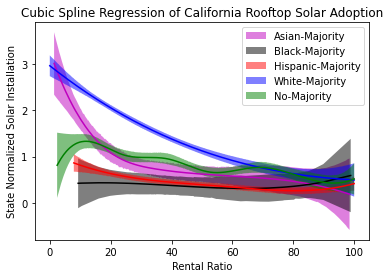

In [ ]:
[df_asian, df_black, df_hisp, df_white, df_no_majority] = sort_dfs(df_asian, df_black, df_hisp, df_white, df_no_majority, 'rental_ratio')

# Asian
[MSE_ave_min_asian, degree_of_freedom_MSE_ave_min_asian, conf_int_asian, y_pred_asian]=spline_rental_ratio_degree_of_freedom_cv_with_CI(df_asian, 5, 3, 9)
plt.plot(df_asian['rental_ratio'], y_pred_asian, 'm')
plt.fill_between(df_asian['rental_ratio'], y_pred_asian-conf_int_asian, y_pred_asian+conf_int_asian, facecolor = 'm', alpha = 0.5, label = 'Asian-Majority')

# Black
[MSE_ave_min_black, degree_of_freedom_MSE_ave_min_black, conf_int_black, y_pred_black]=spline_rental_ratio_degree_of_freedom_cv_with_CI(df_black, 5, 3, 9)
plt.plot(df_black['rental_ratio'], y_pred_black, 'black')
plt.fill_between(df_black['rental_ratio'], y_pred_black-conf_int_black, y_pred_black+conf_int_black, facecolor = 'black', alpha = 0.5, label = 'Black-Majority')

# Hispanic
[MSE_ave_min_hisp, degree_of_freedom_MSE_ave_min_hisp, conf_int_hisp, y_pred_hisp]=spline_rental_ratio_degree_of_freedom_cv_with_CI(df_hisp, 5, 3, 9)
plt.plot(df_hisp['rental_ratio'], y_pred_hisp, 'r')
plt.fill_between(df_hisp['rental_ratio'], y_pred_hisp-conf_int_hisp, y_pred_hisp+conf_int_hisp, facecolor = 'r', alpha = 0.5, label = 'Hispanic-Majority')

# White
[MSE_ave_min_white, degree_of_freedom_MSE_ave_min_white, conf_int_white, y_pred_white]=spline_rental_ratio_degree_of_freedom_cv_with_CI(df_white, 5, 3, 9)
plt.plot(df_white['rental_ratio'], y_pred_white, 'b')
plt.fill_between(df_white['rental_ratio'], y_pred_white-conf_int_white, y_pred_white+conf_int_white, facecolor = 'b', alpha = 0.5, label = 'White-Majority')

# No-Majority
[MSE_ave_min_no_majority, degree_of_freedom_MSE_ave_min_no_majority, conf_int_no_majority, y_pred_no_majority]=spline_rental_ratio_degree_of_freedom_cv_with_CI(df_no_majority, 5, 3, 9)
plt.plot(df_no_majority['rental_ratio'], y_pred_no_majority, 'g')
plt.fill_between(df_no_majority['rental_ratio'], y_pred_no_majority-conf_int_no_majority, y_pred_no_majority+conf_int_no_majority, facecolor = 'g', alpha = 0.5, label = 'No-Majority')

print('The MSE for the Asian-majority tracts:', MSE_ave_min_asian)
print('The MSE for the Black-majority tracts:', MSE_ave_min_black)
print('The MSE for the Hispanic-majority tracts:', MSE_ave_min_hisp)
print('The MSE for the White-majority tracts:', MSE_ave_min_white)
print('The MSE for the No-majority tracts:', MSE_ave_min_no_majority)

deg_of_freedom_rental_asian = degree_of_freedom_MSE_ave_min_asian
deg_of_freedom_rental_black = degree_of_freedom_MSE_ave_min_black
deg_of_freedom_rental_hisp = degree_of_freedom_MSE_ave_min_hisp
deg_of_freedom_rental_white = degree_of_freedom_MSE_ave_min_white
deg_of_freedom_rental_no_majority = degree_of_freedom_MSE_ave_min_no_majority

plt.title('Cubic Spline Regression of California Rooftop Solar Adoption')
plt.xlabel('Rental Ratio')
plt.ylabel('State Normalized Solar Installation')
plt.legend(loc = 'upper right')
plt.show()

As you can see in the figure above, the relationship between the rental ratio and state-normalized solar installation rate is also non-linear. As a larger percentage of the households in the census tract rent their homes, fewer homes have rooftop solar. This is consistent with the expectation based on the split-incentive problem.

Now, that we have established that there is a non-linear relationship between both the rental ratio and the median household income to the state-normalized solar installation rate is there a way to combine them? Yes, we can use GAMs. We will build GAMs out of splines. However, notice that you could use other functions as well, as discussed in the textbook and in class.

Let's start by using the spline fits that were optimal when median income and rental ratio were considered independently. We will make an array to hold these individually optimized degrees of freedom.

In [ ]:
degrees_of_freedom_asian = pd.DataFrame(data = [[deg_of_freedom_income_asian, deg_of_freedom_rental_asian]], columns =  ['median_income', 'rental_ratio'])
degrees_of_freedom_black = pd.DataFrame(data = [[deg_of_freedom_income_black, deg_of_freedom_rental_black]], columns =  ['median_income', 'rental_ratio'])
degrees_of_freedom_hisp  = pd.DataFrame(data = [[deg_of_freedom_income_hisp, deg_of_freedom_rental_hisp]], columns =  ['median_income', 'rental_ratio'])
degrees_of_freedom_white = pd.DataFrame(data = [[deg_of_freedom_income_white, deg_of_freedom_rental_white]], columns =  ['median_income', 'rental_ratio'])
degrees_of_freedom_no_majority = pd.DataFrame(data = [[deg_of_freedom_income_no_majority, deg_of_freedom_rental_no_majority]], columns =  ['median_income', 'rental_ratio'])

We will be using patsy once again but now will need to have a string that is the sum of the two splines. Here is an example of how to automate the creation of this string.

In [ ]:
df = df_asian
degrees_of_freedom = degrees_of_freedom_asian
response_variable = 'solar_install'

l = list(df.columns)
l.remove(response_variable)
string = ''
for feature in l:
    string = string + 'bs(' + feature + ', df='+ str(int(degrees_of_freedom[feature])) + ', degree =' + str(degree) +', include_intercept=True) +'
string = string[:-1]
print(string)

bs(median_income, df=6, degree =3, include_intercept=True) +bs(rental_ratio, df=5, degree =3, include_intercept=True) 


The function, GAMs_with_CI, will fit a GAMs model with a spline of specified degree (degree) and specified  degrees of freedom (degrees_of_freedom) to all feature variables in the dataframe (df). Note the the response variable, in this Data Lab it is 'solar_install', is not a feature. The function will use 5-fold cross-validation to determine the validation average mean squared error. The function will return the validation MSE (MSE_ave), 95% confidence interval (conf_int), and the predicted state-normalized solar installation rate (y_pred).

In [ ]:
def GAMs_with_CI(df, response_variable, k, degree, degrees_of_freedom):
    l = list(df.columns)
    l.remove(response_variable)
    string = ''
    for feature in l:
        string = string + 'bs(' + feature + ', df='+ str(int(degrees_of_freedom[feature])) + ', degree =' + str(degree) +', include_intercept=True) +'
    string = string[:-1]

    mses = pd.DataFrame()
    MSE_array = []
    fold = 0
    kf = KFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(df):
        # Separate each array into respective variables
        df_train = np.asarray(df)[train_index]
        df_train = pd.DataFrame(df_train, columns = df.columns)
        df_val = np.asarray(df)[val_index]
        df_val = pd.DataFrame(df_val, columns = df.columns)

        # Use patsy to generate entire matrix of basis functions
        X_train = pt.dmatrix(string, df_train)
        X_val = pt.dmatrix(string, df_val)

        # Fit linear regression model
        model = sm.OLS(df_train[response_variable], X_train).fit(disp=0)
        y_pred = model.predict(X_val)

        MSE = mean_squared_error(df_val[response_variable], y_pred)
        MSE_array.append(MSE)

    # Average the MSE across folds
    MSE_ave = np.mean(MSE_array)

    # Calculate the 95% confidence interval
    X = pt.dmatrix(string, df)
    y = np.asarray(df[response_variable])

    # Fit GAMs model
    model = sm.OLS(y, X).fit(disp=0)
    y_pred = model.predict(X)
    conf_int = confidence_interval(X, y, y_pred)

    return MSE_ave, conf_int, y_pred

MSE for GAMs with 2 features (median income & rental ratio) for Asian-majority: 0.8213608597340292
MSE for GAMs with 2 features (median income & rental ratio) for Black-majority: 0.7550491480748316
MSE for GAMs with 2 features (median income & rental ratio) for Hispanic-majority: 0.19366269650773432
MSE for GAMs with 2 features (median income & rental ratio) for White-majority: 1.3644935492595949
MSE for GAMs with 2 features (median income & rental ratio) for No-majority: 0.7203914778170141


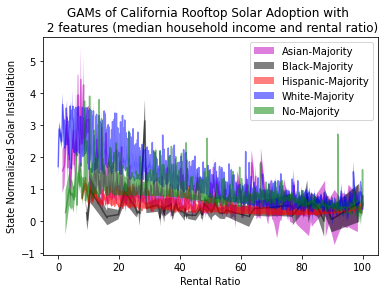

In [ ]:
# Plot relative to rental ratio

response_variable = 'solar_install'
column_to_plot = 'rental_ratio'
k = 5
degree = 3

# Sort data by the column to plot
[df_asian, df_black, df_hisp, df_white, df_no_majority] = sort_dfs(df_asian, df_black, df_hisp, df_white, df_no_majority, column_to_plot)


[MSE_ave_asian, conf_int_asian, y_pred_asian]= GAMs_with_CI(df_asian, response_variable, k, degree, degrees_of_freedom_asian)
[MSE_ave_black, conf_int_black, y_pred_black]= GAMs_with_CI(df_black, response_variable, k, degree, degrees_of_freedom_black)
[MSE_ave_hisp, conf_int_hisp, y_pred_hisp]= GAMs_with_CI(df_hisp, response_variable, k, degree, degrees_of_freedom_hisp)
[MSE_ave_white, conf_int_white, y_pred_white]= GAMs_with_CI(df_white, response_variable, k, degree, degrees_of_freedom_white)
[MSE_ave_no_majority, conf_int_no_majority, y_pred_no_majority]= GAMs_with_CI(df_no_majority, response_variable, k, degree, degrees_of_freedom_no_majority)

print('MSE for GAMs with 2 features (median income & rental ratio) for Asian-majority:', np.mean(MSE_ave_asian))
print('MSE for GAMs with 2 features (median income & rental ratio) for Black-majority:', np.mean(MSE_ave_black))
print('MSE for GAMs with 2 features (median income & rental ratio) for Hispanic-majority:', np.mean(MSE_ave_hisp))
print('MSE for GAMs with 2 features (median income & rental ratio) for White-majority:', np.mean(MSE_ave_white))
print('MSE for GAMs with 2 features (median income & rental ratio) for No-majority:', np.mean(MSE_ave_no_majority))

plt.plot(df_asian[column_to_plot], y_pred_asian, 'm', alpha = 0.5)
plt.fill_between(df_asian[column_to_plot], y_pred_asian-conf_int_asian, y_pred_asian+conf_int_asian, facecolor = 'm', alpha = 0.5, label = 'Asian-Majority')

plt.plot(df_black[column_to_plot], y_pred_black, 'black', alpha = 0.5)
plt.fill_between(df_black[column_to_plot], y_pred_black-conf_int_black, y_pred_black+conf_int_black, facecolor = 'black', alpha = 0.5, label = 'Black-Majority')

plt.plot(df_hisp[column_to_plot], y_pred_hisp, 'r', alpha = 0.5)
plt.fill_between(df_hisp[column_to_plot], y_pred_hisp-conf_int_hisp, y_pred_hisp+conf_int_hisp, facecolor = 'r', alpha = 0.5, label = 'Hispanic-Majority')

plt.plot(df_white[column_to_plot], y_pred_white, 'b', alpha = 0.5)
plt.fill_between(df_white[column_to_plot], y_pred_white-conf_int_white, y_pred_white+conf_int_white, facecolor = 'b', alpha = 0.5, label = 'White-Majority')

plt.plot(df_no_majority[column_to_plot], y_pred_no_majority, 'g', alpha = 0.5)
plt.fill_between(df_no_majority[column_to_plot], y_pred_no_majority-conf_int_no_majority, y_pred_no_majority+conf_int_no_majority, facecolor = 'g', alpha = 0.5, label = 'No-Majority')

plt.title('GAMs of California Rooftop Solar Adoption with \n 2 features (median household income and rental ratio)')
plt.xlabel('Rental Ratio')
plt.ylabel('State Normalized Solar Installation')
plt.legend(loc = 'upper right')
plt.show()

MSE for GAMs with 2 features (median income & rental ratio) for Asian-majority: 0.875370521905268
MSE for GAMs with 2 features (median income & rental ratio) for Black-majority: 0.6643965499565527
MSE for GAMs with 2 features (median income & rental ratio) for Hispanic-majority: 0.1929675636149923
MSE for GAMs with 2 features (median income & rental ratio) for White-majority: 1.3641943420238236
MSE for GAMs with 2 features (median income & rental ratio) for No-majority: 0.7245384690339222


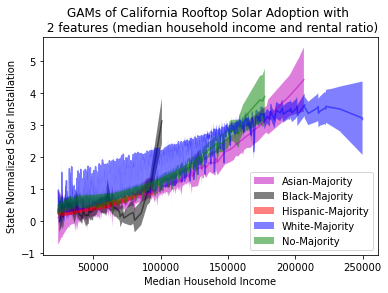

In [ ]:
# Plot relative to median household income

response_variable = 'solar_install'
column_to_plot = 'median_income'
k = 5
degree = 3

# Sort data by the column to plot
[df_asian, df_black, df_hisp, df_white, df_no_majority] = sort_dfs(df_asian, df_black, df_hisp, df_white, df_no_majority, column_to_plot)


[MSE_ave_asian, conf_int_asian, y_pred_asian]= GAMs_with_CI(df_asian, response_variable, k, degree, degrees_of_freedom_asian)
[MSE_ave_black, conf_int_black, y_pred_black]= GAMs_with_CI(df_black, response_variable, k, degree, degrees_of_freedom_black)
[MSE_ave_hisp, conf_int_hisp, y_pred_hisp]= GAMs_with_CI(df_hisp, response_variable, k, degree, degrees_of_freedom_hisp)
[MSE_ave_white, conf_int_white, y_pred_white]= GAMs_with_CI(df_white, response_variable, k, degree, degrees_of_freedom_white)
[MSE_ave_no_majority, conf_int_no_majority, y_pred_no_majority]= GAMs_with_CI(df_no_majority, response_variable, k, degree, degrees_of_freedom_no_majority)

print('MSE for GAMs with 2 features (median income & rental ratio) for Asian-majority:', np.mean(MSE_ave_asian))
print('MSE for GAMs with 2 features (median income & rental ratio) for Black-majority:', np.mean(MSE_ave_black))
print('MSE for GAMs with 2 features (median income & rental ratio) for Hispanic-majority:', np.mean(MSE_ave_hisp))
print('MSE for GAMs with 2 features (median income & rental ratio) for White-majority:', np.mean(MSE_ave_white))
print('MSE for GAMs with 2 features (median income & rental ratio) for No-majority:', np.mean(MSE_ave_no_majority))

plt.plot(df_asian[column_to_plot], y_pred_asian, 'm', alpha = 0.5)
plt.fill_between(df_asian[column_to_plot], y_pred_asian-conf_int_asian, y_pred_asian+conf_int_asian, facecolor = 'm', alpha = 0.5, label = 'Asian-Majority')

plt.plot(df_black[column_to_plot], y_pred_black, 'black', alpha = 0.5)
plt.fill_between(df_black[column_to_plot], y_pred_black-conf_int_black, y_pred_black+conf_int_black, facecolor = 'black', alpha = 0.5, label = 'Black-Majority')

plt.plot(df_hisp[column_to_plot], y_pred_hisp, 'r', alpha = 0.5)
plt.fill_between(df_hisp[column_to_plot], y_pred_hisp-conf_int_hisp, y_pred_hisp+conf_int_hisp, facecolor = 'r', alpha = 0.5, label = 'Hispanic-Majority')

plt.plot(df_white[column_to_plot], y_pred_white, 'b', alpha = 0.5)
plt.fill_between(df_white[column_to_plot], y_pred_white-conf_int_white, y_pred_white+conf_int_white, facecolor = 'b', alpha = 0.5, label = 'White-Majority')

plt.plot(df_no_majority[column_to_plot], y_pred_no_majority, 'g', alpha = 0.5)
plt.fill_between(df_no_majority[column_to_plot], y_pred_no_majority-conf_int_no_majority, y_pred_no_majority+conf_int_no_majority, facecolor = 'g', alpha = 0.5, label = 'No-Majority')

plt.title('GAMs of California Rooftop Solar Adoption with \n 2 features (median household income and rental ratio)')
plt.xlabel('Median Household Income')
plt.ylabel('State Normalized Solar Installation')
plt.legend(loc = 'lower right')
plt.show()

**Exercise 13:** When we created the GAMs models, we had used the degrees of freedom that had been optimized based on splines of the features (median_income and rental_ratio) individually using k-fold cross-validation. When both features are considered together, the optimal degrees of freedom to use for each feature may change. To test this, please develop code to use 5-fold cross-validation to determine the optimal degrees of freedom when both features are considered together. (a) Determine the optimal degrees of freedom for each feature. (b) Explain why one would expect these are the same or different than those found individually.

In [ ]:

# Asian
[MSE_ave_min_asian, degree_of_freedom_MSE_ave_min_asian, conf_int_asian, y_pred_asian]=spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_asian, 5, 3, 9)

# Black
[MSE_ave_min_black, degree_of_freedom_MSE_ave_min_black, conf_int_black, y_pred_black]=spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_black, 5, 3, 9)


# Hispanic
[MSE_ave_min_hisp, degree_of_freedom_MSE_ave_min_hisp, conf_int_hisp, y_pred_hisp]=spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_hisp, 5, 3, 9)

#white
[MSE_ave_min_white, degree_of_freedom_MSE_ave_min_white, conf_int_white, y_pred_white]=spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_white, 5, 3, 9)

# No-Majority
[MSE_ave_min_no_majority, degree_of_freedom_MSE_ave_min_no_majority, conf_int_no_majority, y_pred_no_majority]=spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_no_majority, 5, 3, 9)


deg_of_freedom_rental_asian = degree_of_freedom_MSE_ave_min_asian
deg_of_freedom_rental_black = degree_of_freedom_MSE_ave_min_black
deg_of_freedom_rental_hisp = degree_of_freedom_MSE_ave_min_hisp
deg_of_freedom_rental_white = degree_of_freedom_MSE_ave_min_white
deg_of_freedom_rental_no_majority = degree_of_freedom_MSE_ave_min_no_majority

print(deg_of_freedom_rental_asian)
print(deg_of_freedom_rental_black)
print(deg_of_freedom_rental_hisp)
print(deg_of_freedom_rental_white)
print(deg_of_freedom_rental_no_majority)


4
4
4
4
4


In [ ]:
def spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df, k, degree, degree_of_freedom_max):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    for train_index, val_index in kf.split(df):
        # Separate each array into respective variables
        df_train = np.asarray(df)[train_index]
        df_train = pd.DataFrame(df_train, columns = df.columns)
        df_val = np.asarray(df)[val_index]
        df_val = pd.DataFrame(df_val, columns = df.columns)

        # Calculate the MSE for each degree of freedom
        MSE_array = []
        for deg_of_freedom in range(degree + 1,degree_of_freedom_max+1):
            # Use patsy to generate entire matrix of basis functions

            l = list(df.columns)
            l.remove(response_variable)
            string = ''
            for feature in l:
                string = string + 'bs(' + feature + ', df='+ str(int(degrees_of_freedom[feature])) + ', degree =' + str(degree) +', include_intercept=True) +'
            string = string[:-1]

            X_train = pt.dmatrix(string, df_train)
            X_val = pt.dmatrix(string, df_val)

            # Fit linear regression model
            model = sm.OLS(df_train.solar_install, X_train).fit(disp=0)
            y_pred = model.predict(X_val)

            MSE = mean_squared_error(df_val.solar_install, y_pred)
            MSE_array.append(MSE)

        mses[fold] = MSE_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and the polynomial order where it occurs
    MSE_ave_min = min(mses.mses_ave)
    degree_of_freedom_MSE_ave_min = mses['mses_ave'].idxmin()+degree+1

    # Calculate the 95% confidence interval
    l = list(df.columns)
    l.remove(response_variable)
    string = ''
    for feature in l:
        string = string + 'bs(' + feature + ', df='+ str(int(degrees_of_freedom[feature])) + ', degree =' + str(degree) +', include_intercept=True) +'
    string = string[:-1]
    X = pt.dmatrix(string, df)
    y = np.asarray(df['solar_install'])

    # Fit the regression model
    model = sm.OLS(y, X).fit(disp=0)
    y_pred = model.predict(X)
    conf_int = confidence_interval(X, y, y_pred)

    return MSE_ave_min, degree_of_freedom_MSE_ave_min, conf_int, y_pred

In [ ]:
# I expect it to be different because in the first case the degree was calculated with the second feature set to zero, while in the secod case
# the optimal degree was calculated while holding the second feature constant

 One of the shortcomings of the GAMs model is its inability to automatically account for interactions between features. One way to combat this shortcoming is to add an interaction term as another feature in the X matrix. Household income and home ownership are highly related. Households with low income are more likely to rent the home where they live. For each of the racial/ethnic majority groups, add a column to the feature matrix that is the multiplication of the median_income and rental_ratio and call this column "interaction." Using this as a new feature matrix repeat the analysis. Determine the appropriate degrees of freedom to use to fit cubic splines. Create a GAMs with cubic splines of all three features (median_income, rental_ratio, and interaction). (a) Determine the 5-fold cross-validation mean squared error for each racial/ethnic majority group. (b) Plot **median household income** vs state-normalized solar installation rate for each racial/ethnice majority group, showing the 95% confidence intervals. (c) Plot **rental ratio** vs state-normalized solar installation rate for each racial/ethnice majority group, showing the 95% confidence intervals.

In [ ]:


df_asian['interaction'] = df_asian['median_income']*df_asian['rental_ratio']
df_black['interaction'] = df_black['median_income']*df_black['rental_ratio']
df_hisp['interaction'] = df_hisp['median_income']*df_hisp['rental_ratio']
df_white['interaction'] = df_white['median_income']*df_white['rental_ratio']
df_no_majority['interaction'] = df_no_majority['median_income']*df_no_majority['rental_ratio']


spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_asian, k, degree, degree_of_freedom_max)
spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_black, k, degree, degree_of_freedom_max)
spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_hisp, k, degree, degree_of_freedom_max)
spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_white, k, degree, degree_of_freedom_max)
spline_rental_ratio_degree_of_freedom_cv_with_CI_2_features(df_no_majority, k, degree, degree_of_freedom_max)

Consider the advantage and disadvantages of GAMs. Be sure to discuss how the validation mean squared error changed, especially for different racial/ethnic majority groups. Include a discussion on the curse of dimensionality and how that relates to the results you obtained.

In [ ]:
# Advantages:
#GAMs are good at modelling highly non-linear relationships; are additive so are easier to interpret; make better predictions than other models s
# studied so far
#disadvantages:
#GAMs are restricted to additive formats and hence cannot capture certain non-linear relationships